In [2]:
import argparse
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import glob

from dcase_models.model.container import *
from dcase_models.data.data_generator import DataGenerator
from dcase_models.data.features import MelSpectrogram
from dcase_models.data.datasets import UrbanSound8k
from dcase_models.util.files import load_json, mkdir_if_not_exists, save_pickle, load_pickle
from dcase_models.util.data import evaluation_setup

sys.path.append('../')
from apnet.model import *
from apnet.layers import PrototypeLayer, WeightedSum

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
dataset_name = 'UrbanSound8k'
model_name = 'APNet'
features_name = 'MelSpectrogram'
fold_name = 'fold8'

In [4]:
# Get parameters
exp_path = '../experiments'
model_folder = os.path.join(exp_path, dataset_name, model_name)
parameters_file = os.path.join(model_folder, 'config.json')
params = load_json(parameters_file)
params_dataset = params['datasets'][dataset_name]
params_features = params['features'][features_name]
params_model = params['models'][model_name]

In [5]:
dataset_path = os.path.join(exp_path, params_dataset['dataset_path'])
dataset = UrbanSound8k(dataset_path)
dataset.check_if_downloaded()

True

In [6]:
features = MelSpectrogram(**params_features)
features.check_if_extracted(dataset)
features.extract(dataset)

In [7]:
exp_folder = os.path.join(model_folder, fold_name)
scaler = load_pickle(os.path.join(exp_folder, 'scaler.pickle'))

model_container = APNet(
    model=None, model_path=exp_folder, 
    custom_objects={
        'PrototypeLayer': PrototypeLayer,
        'WeightedSum': WeightedSum
    },
    metrics=['classification'],
    **params['models'][model_name]['model_arguments']
)
model_container.load_model_weights(exp_folder)
model_container.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 84, 128)      0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 21, 32, 32), 52096       input[0][0]                      
__________________________________________________________________________________________________
features (Lambda)               (None, 21, 32, 32)   0           encoder[1][0]                    
__________________________________________________________________________________________________
prototype_distances (PrototypeL (None, 50, 32)       1075200     features[0][0]                   
__________________________________________________________________________________________________
similarity

In [8]:
folds_train, folds_val, _ = evaluation_setup(
    fold_name, dataset.fold_list,
    params_dataset['evaluation_mode'],
    use_validate_set=True
)
data_gen = DataGenerator(
    dataset, features, folds=folds_train,
    batch_size=params['train']['batch_size'],
    shuffle=False, train=True, scaler=scaler
)

In [9]:
X, Y = data_gen.get_data()
print(X.shape, Y.shape)

(7110, 84, 128) (7110, 10)


In [10]:
#prototypes = load_pickle(os.path.join(exp_folder, 'prototypes.pickle'))
model_container.get_prototypes(X)
prototypes = model_container.prototypes
prototypes.sort()

Getting prototypes (spectrograms)...
Done!
Converting to audio...
Done!


(50, 10)


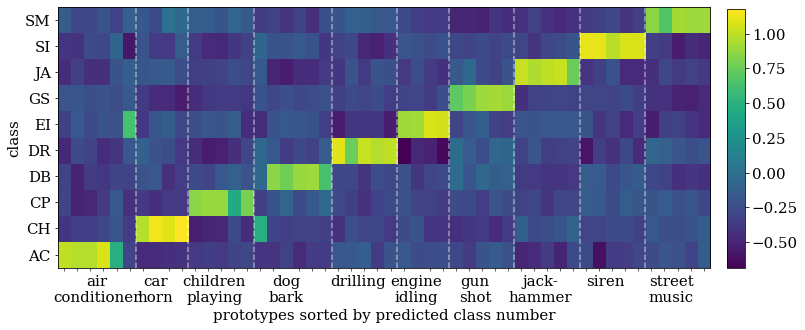

In [18]:
plt.rcParams.update({'font.size': 15, 'font.family': 'serif'})

class_names = (['air\nconditioner', 'car\nhorn', 'children\nplaying',
           'dog\nbark', 'drilling', 'engine\nidling', 'gun\nshot',
           'jack-\nhammer', 'siren', 'street\nmusic'])  
class_names_av = ['AC', 'CH', 'CP', 'DB', 'DR', 'EI', 'GS', 'JA', 'SI', 'SM']
n_classes = len(dataset.label_list)
#model_path = os.path.join(args.models[0], args.dataset, args.fold)
#prototypes = load_pickle(os.path.join(model_path, 'prototypes.pickle'))
weights = prototypes.W_dense
classes_sort = prototypes.classes   
print(weights.shape)

class_sort_diff = np.diff(classes_sort)
class_sort_diff = np.concatenate((class_sort_diff,np.ones(1,)*10),axis=0)
class_sort_diff_ixs = np.where(class_sort_diff)[0]
class_sort_diff_ixs = np.concatenate((np.zeros(1,),class_sort_diff_ixs),axis=0)

fig, ax = plt.subplots(figsize=(12,6))
im = ax.imshow(weights.T,origin='lower',)
ax.set_xlabel('prototypes sorted by predicted class number')
ax.set_ylabel('class')
ax.set_xticks(range(len(classes_sort)),minor=True)
ax.set_xticklabels([])
ax.set_xticks(class_sort_diff_ixs[:10] + np.diff(class_sort_diff_ixs)/2.)
ax.set_yticks(np.arange(n_classes),minor=False)
ax.set_yticklabels(class_names_av)
for j in range(1,len(class_sort_diff_ixs)-1):
    plt.plot([class_sort_diff_ixs[j]+0.5, class_sort_diff_ixs[j]+0.5],[-0.5, 9.5],'w--',alpha=0.5)
ax.set_aspect(2)
ax.set_xticklabels(class_names,minor=False)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_horizontalalignment('center')
plt.tick_params(axis='x',which='major',top=False,bottom=False)
plt.tick_params(axis='x',which='minor',bottom=True,length=3)
#fig.colorbar(im,orientation='horizontal')
#plt.tight_layout()

fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.2, 0.02, 0.6])
fig.colorbar(im, cax=cbar_ax)

#plt.tight_layout()
plt.savefig('images/dense_weigths.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()  